# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Random Forest Classifier with scikit-learn 

In [16]:
import sys
sys.path.append('../../')

In [17]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [18]:
from backtesting import Strategy
from sklearn.ensemble import RandomForestClassifier

## Getting the Data

In [19]:
XAUUSD = load_data()

In [20]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [21]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [22]:
class Random_Forest_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [23]:
strategy = Random_Forest_Classifier
account_size = 10000
folder_ML_Strategy = 'Random Forest Classifier'

In [24]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
from util.ATR import *
from util.SMA import *
from util.RSI import *
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_RFC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        df['ATR'] = ATR(df, 20)['ATR']

        periods = 14
        moving_av = 3

        df["roll_low"] = df['Low'].rolling(periods).min()
        df["roll_high"] = df['High'].rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100
        df["D"] = df.K.rolling(moving_av).mean()

        df = df.drop('roll_low', axis=1)
        df = df.drop('roll_high', axis=1)

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        # df = df.dropna()

        df.fillna(0, inplace=True)


        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        y_train = self.data_train['signal'].copy()
        x_train = self.data_train.drop(columns=['signal'])
        x_test = self.data_test.drop(columns=['signal'])

        self.model = RandomForestClassifier()
        self.model.fit(x_train, y_train)

        # Make predictions
        self.data_train['pred'] = self.model.predict(x_train)
        self.data_test['pred'] = self.model.predict(x_test)

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [25]:
ML_Class = ML_RFC

## TF D1

In [26]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [27]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [28]:
train, test = ml.Run()

### In-Sample Backtesting

In [29]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 41434.290614
Equity Peak [$]                  41434.297614
Return [%]                         314.342906
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    9.243233
Volatility (Ann.) [%]                0.814755
Sharpe Ratio                        11.344807
Sortino Ratio                      241.693845
Calmar Ratio                        165.39775
Max. Drawdown [%]                   -0.055885
Avg. Drawdown [%]                   -0.006814
Max. Drawdown Duration        6 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                 2090
Win Rate [%]                        96.937799
Best Trade [%]                      15.822334
Worst Trade [%]                     -0.795939
Avg. Trade [%]                    

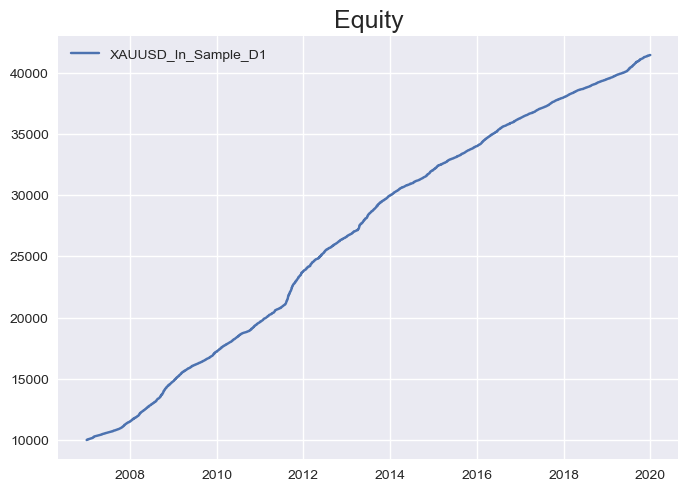

In [30]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [31]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                 10207.359201
Equity Peak [$]                  10213.875347
Return [%]                           2.073592
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    0.523263
Volatility (Ann.) [%]                2.676603
Sharpe Ratio                         0.195495
Sortino Ratio                        0.289271
Calmar Ratio                         0.104183
Max. Drawdown [%]                   -5.022536
Avg. Drawdown [%]                   -1.013232
Max. Drawdown Duration      967 days 00:00:00
Avg. Drawdown Duration      129 days 00:00:00
# Trades                                  244
Win Rate [%]                        51.639344
Best Trade [%]                       5.934507
Worst Trade [%]                     -6.208306
Avg. Trade [%]                    

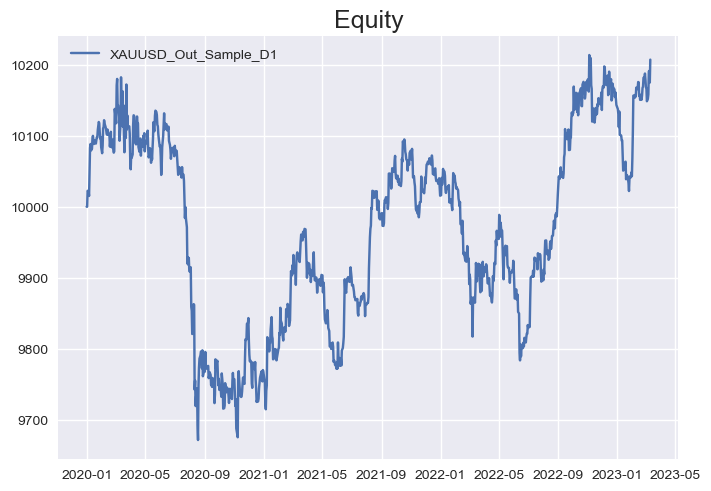

In [32]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [33]:
filename_train = f'result_{TF}_In_Sample.csv'

In [34]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [35]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [36]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [37]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [38]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [39]:
train, test = ml.Run()

### In-Sample Backtesting

In [40]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                 74727.591325
Equity Peak [$]                  74730.681263
Return [%]                         647.275913
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                   13.324437
Volatility (Ann.) [%]                 1.01006
Sharpe Ratio                        13.191729
Sortino Ratio                      527.532265
Calmar Ratio                       275.691296
Max. Drawdown [%]                   -0.048331
Avg. Drawdown [%]                   -0.001529
Max. Drawdown Duration        4 days 08:00:00
Avg. Drawdown Duration        0 days 19:00:00
# Trades                                10750
Win Rate [%]                        95.330233
Best Trade [%]                       11.36876
Worst Trade [%]                     -0.781987
Avg. Trade [%]                    

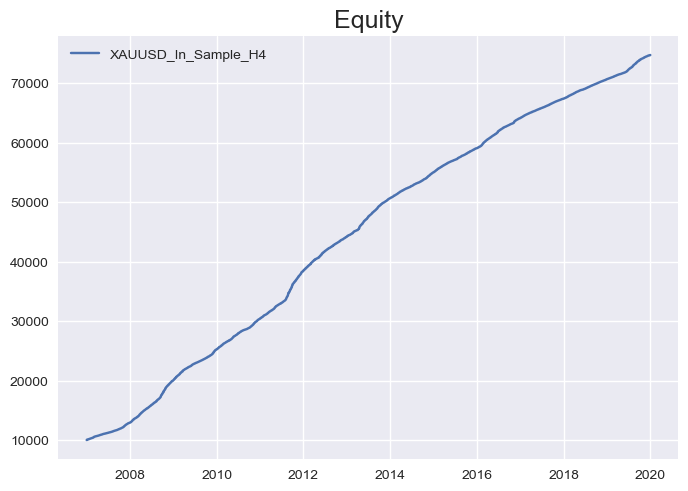

In [41]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [42]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                  9411.719566
Equity Peak [$]                  10129.729365
Return [%]                          -5.882804
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -1.529913
Volatility (Ann.) [%]                2.668604
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.474869
Avg. Drawdown [%]                   -0.969455
Max. Drawdown Duration     1093 days 04:00:00
Avg. Drawdown Duration       89 days 11:00:00
# Trades                                 1792
Win Rate [%]                        48.772321
Best Trade [%]                       4.558713
Worst Trade [%]                     -5.591309
Avg. Trade [%]                    

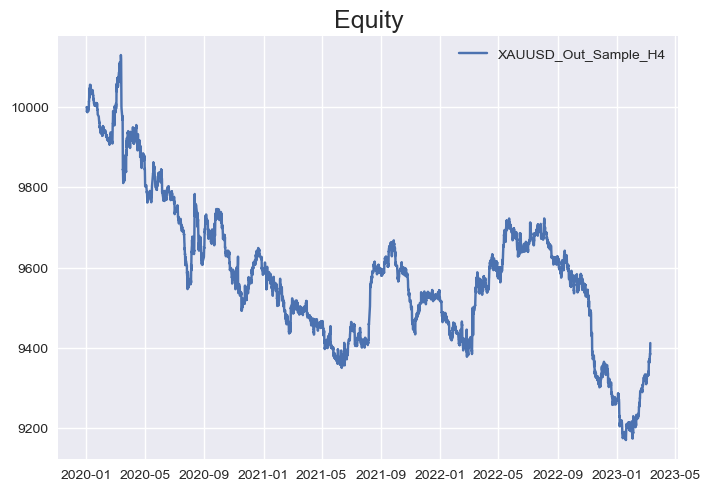

In [43]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [44]:
filename_train = f'result_{TF}_In_Sample.csv'

In [45]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [46]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [47]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [48]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [49]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [50]:
train, test = ml.Run()

### In-Sample Backtesting

In [51]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                128386.593244
Equity Peak [$]                 128387.679783
Return [%]                        1183.865932
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                   17.201259
Volatility (Ann.) [%]                1.397165
Sharpe Ratio                        12.311541
Sortino Ratio                     1239.763562
Calmar Ratio                       494.475699
Max. Drawdown [%]                   -0.034787
Avg. Drawdown [%]                    -0.00086
Max. Drawdown Duration        3 days 16:00:00
Avg. Drawdown Duration        0 days 05:00:00
# Trades                                41586
Win Rate [%]                        91.249459
Best Trade [%]                      10.914605
Worst Trade [%]                     -0.950574
Avg. Trade [%]                    

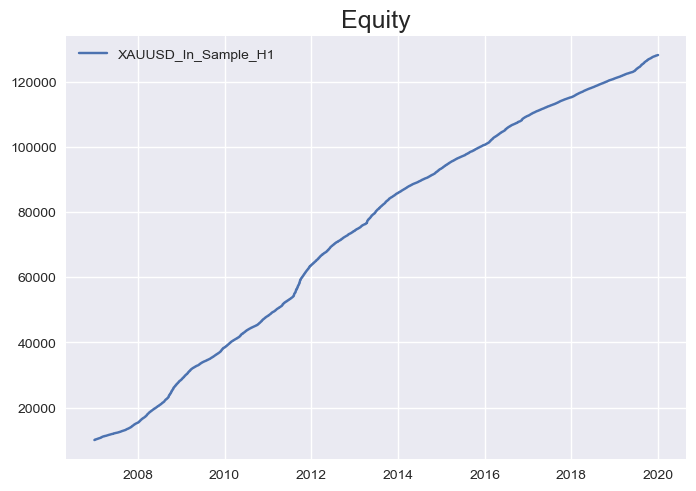

In [52]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [53]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                  7703.349301
Equity Peak [$]                  10003.065128
Return [%]                         -22.966507
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -6.419812
Volatility (Ann.) [%]                2.918448
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.334972
Avg. Drawdown [%]                  -11.869802
Max. Drawdown Duration     1157 days 15:00:00
Avg. Drawdown Duration      581 days 21:00:00
# Trades                                 6794
Win Rate [%]                        50.191345
Best Trade [%]                       5.413433
Worst Trade [%]                     -4.000468
Avg. Trade [%]                    

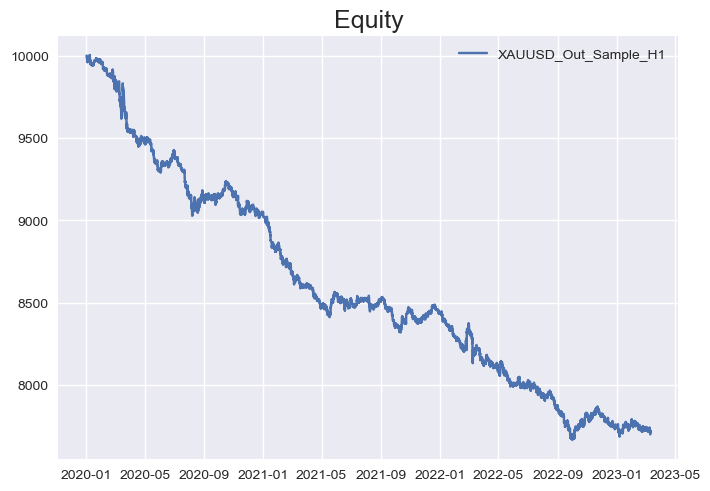

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [55]:
filename_train = f'result_{TF}_In_Sample.csv'

In [56]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [57]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [58]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [59]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [60]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [61]:
train, test = ml.Run()

### In-Sample Backtesting

In [62]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                170147.765367
Equity Peak [$]                 170148.788898
Return [%]                        1601.477654
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                   19.275404
Volatility (Ann.) [%]                1.657544
Sharpe Ratio                        11.628894
Sortino Ratio                      1987.38923
Calmar Ratio                       476.889123
Max. Drawdown [%]                   -0.040419
Avg. Drawdown [%]                   -0.000652
Max. Drawdown Duration        3 days 11:00:00
Avg. Drawdown Duration        0 days 02:29:00
# Trades                                82680
Win Rate [%]                        88.109579
Best Trade [%]                       8.092709
Worst Trade [%]                     -0.982087
Avg. Trade [%]                    

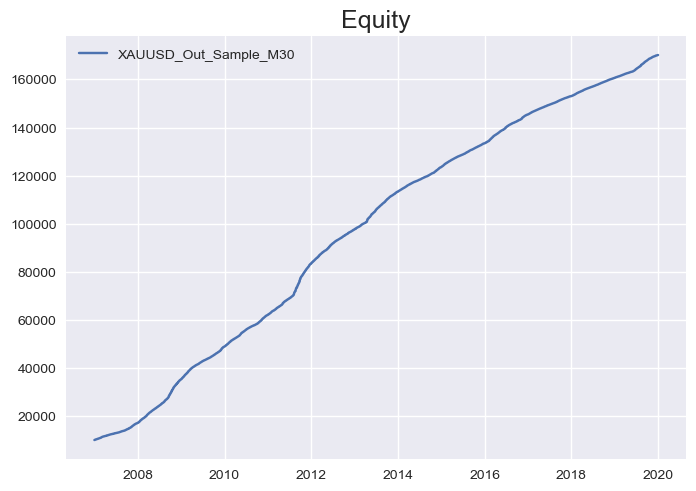

In [63]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [64]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                  5533.911913
Equity Peak [$]                  10000.832502
Return [%]                         -44.660881
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                   -13.96879
Volatility (Ann.) [%]                2.855553
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -44.665487
Avg. Drawdown [%]                  -44.665487
Max. Drawdown Duration     1163 days 17:00:00
Avg. Drawdown Duration     1163 days 17:00:00
# Trades                                14107
Win Rate [%]                        48.784291
Best Trade [%]                       4.262128
Worst Trade [%]                     -3.222091
Avg. Trade [%]                    

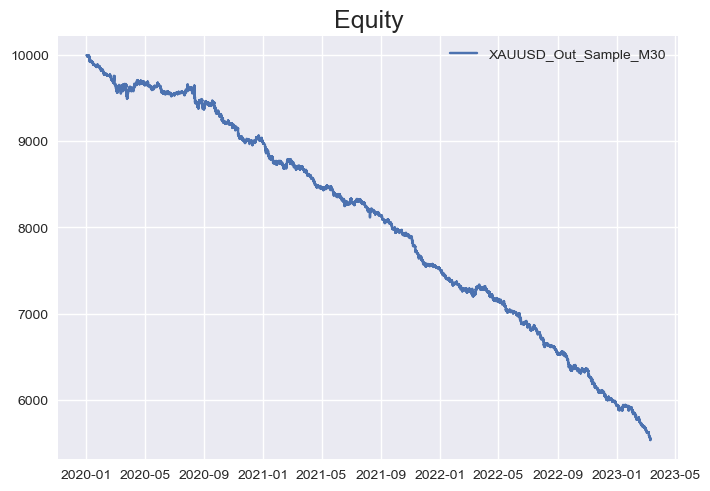

In [65]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [66]:
filename_train = f'result_{TF}_In_Sample.csv'

In [67]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [68]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [69]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [70]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [71]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [72]:
train, test = ml.Run()

### In-Sample Backtesting

In [73]:
train

Start                     2014-09-23 13:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 08:45:00
Exposure Time [%]                   99.998394
Equity Final [$]                 75401.942123
Equity Peak [$]                  75402.862622
Return [%]                         654.019421
Buy & Hold Return [%]                23.74151
Return (Ann.) [%]                   36.360964
Volatility (Ann.) [%]                2.924194
Sharpe Ratio                        12.434526
Sortino Ratio                     1560.501076
Calmar Ratio                       391.665638
Max. Drawdown [%]                   -0.092837
Avg. Drawdown [%]                   -0.000559
Max. Drawdown Duration        3 days 10:30:00
Avg. Drawdown Duration        0 days 01:11:00
# Trades                                64799
Win Rate [%]                        82.408679
Best Trade [%]                       3.031335
Worst Trade [%]                     -1.240326
Avg. Trade [%]                    

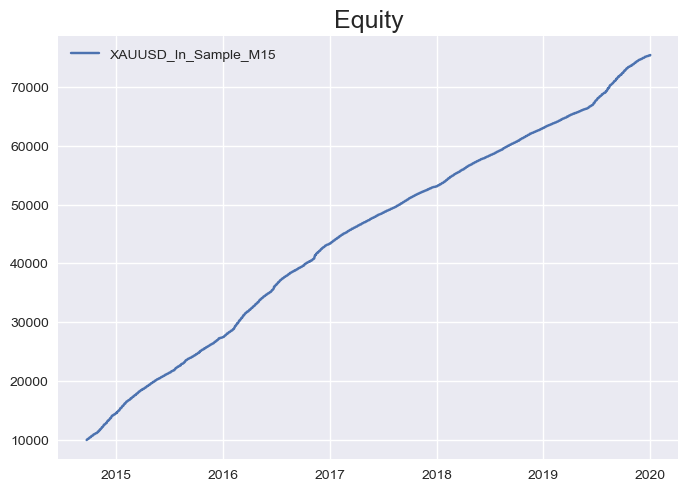

In [74]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [75]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:45:00
Exposure Time [%]                   99.997348
Equity Final [$]                  5500.566033
Equity Peak [$]                  10011.362807
Return [%]                          -44.99434
Buy & Hold Return [%]               22.657555
Return (Ann.) [%]                  -14.097401
Volatility (Ann.) [%]                2.704253
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -45.079954
Avg. Drawdown [%]                   -3.283589
Max. Drawdown Duration     1156 days 01:45:00
Avg. Drawdown Duration       83 days 02:53:00
# Trades                                15420
Win Rate [%]                        52.846952
Best Trade [%]                       2.760841
Worst Trade [%]                     -2.658598
Avg. Trade [%]                    

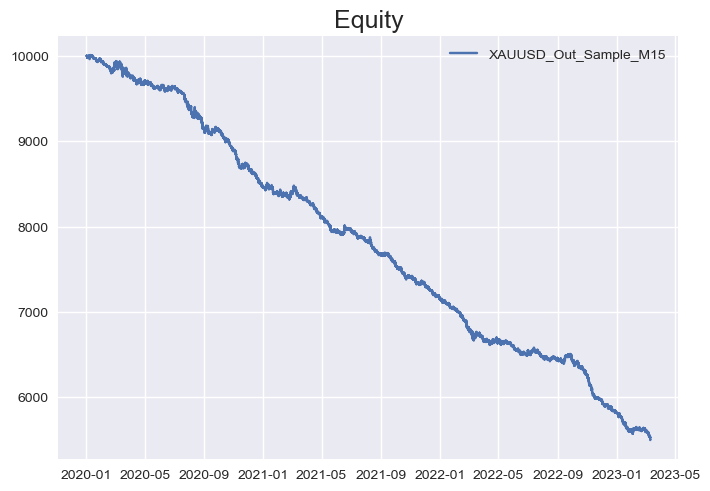

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [77]:
filename_train = f'result_{TF}_In_Sample.csv'

In [78]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [79]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [80]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [81]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [82]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [83]:
train, test = ml.Run()

### In-Sample Backtesting

In [84]:
train

Start                     2020-05-15 11:10:00
End                       2022-12-30 21:55:00
Duration                    959 days 10:45:00
Exposure Time [%]                   99.998928
Equity Final [$]                 104223.98873
Equity Peak [$]                 104225.203435
Return [%]                         942.239887
Buy & Hold Return [%]                5.144305
Return (Ann.) [%]                  105.477387
Volatility (Ann.) [%]                11.40984
Sharpe Ratio                         9.244423
Sortino Ratio                     2115.876728
Calmar Ratio                       812.599295
Max. Drawdown [%]                   -0.129802
Avg. Drawdown [%]                   -0.000653
Max. Drawdown Duration        3 days 05:05:00
Avg. Drawdown Duration        0 days 00:27:00
# Trades                                95766
Win Rate [%]                        76.483303
Best Trade [%]                       2.869017
Worst Trade [%]                     -0.896517
Avg. Trade [%]                    

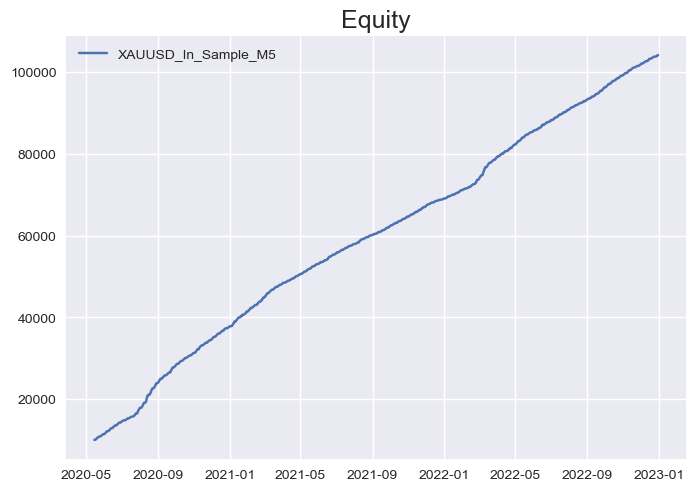

In [85]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [86]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:55:00
Exposure Time [%]                    99.98507
Equity Final [$]                  7948.144312
Equity Peak [$]                       10000.0
Return [%]                         -20.518557
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  -62.423333
Volatility (Ann.) [%]                1.309626
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.674891
Avg. Drawdown [%]                  -20.674891
Max. Drawdown Duration       66 days 18:50:00
Avg. Drawdown Duration       66 days 18:50:00
# Trades                                 5832
Win Rate [%]                         36.38546
Best Trade [%]                       0.925985
Worst Trade [%]                     -0.791778
Avg. Trade [%]                    

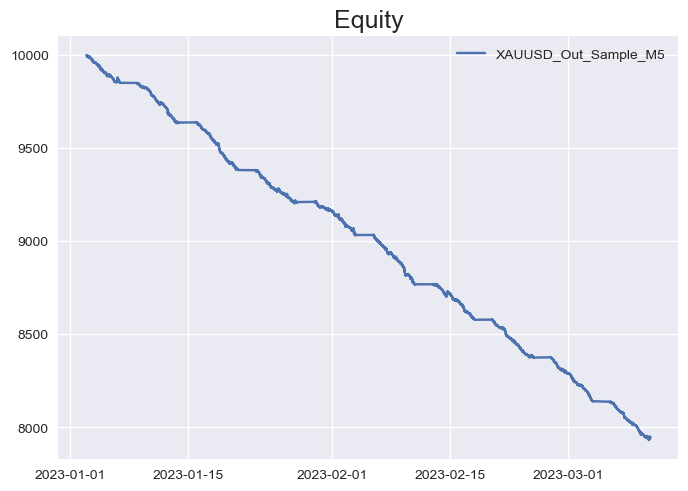

In [87]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [88]:
filename_train = f'result_{TF}_In_Sample.csv'

In [89]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [90]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [91]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [92]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [93]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [94]:
train, test = ml.Run()

### In-Sample Backtesting

In [95]:
train

Start                     2022-08-16 23:13:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:45:00
Exposure Time [%]                   99.998497
Equity Final [$]                 24117.709639
Equity Peak [$]                  24121.674744
Return [%]                         141.177096
Buy & Hold Return [%]                2.688945
Return (Ann.) [%]                  566.711867
Volatility (Ann.) [%]               58.968971
Sharpe Ratio                          9.61034
Sortino Ratio                     9307.196597
Calmar Ratio                      2430.030655
Max. Drawdown [%]                   -0.233212
Avg. Drawdown [%]                   -0.002842
Max. Drawdown Duration        3 days 20:16:00
Avg. Drawdown Duration        0 days 00:15:00
# Trades                                65862
Win Rate [%]                        51.755185
Best Trade [%]                       1.277065
Worst Trade [%]                     -0.398337
Avg. Trade [%]                    

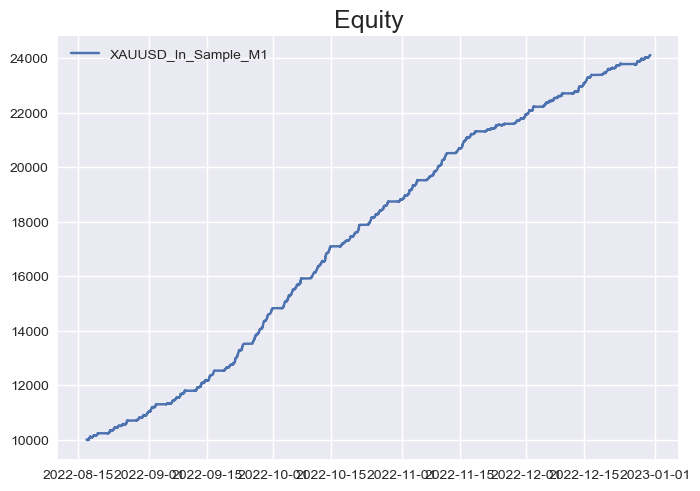

In [96]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [97]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:59:00
Exposure Time [%]                   99.997013
Equity Final [$]                  7131.225447
Equity Peak [$]                       10000.0
Return [%]                         -28.687746
Buy & Hold Return [%]                2.050818
Return (Ann.) [%]                  -76.357043
Volatility (Ann.) [%]                2.093181
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -28.697016
Avg. Drawdown [%]                  -28.697016
Max. Drawdown Duration       66 days 18:58:00
Avg. Drawdown Duration       66 days 18:58:00
# Trades                                 8187
Win Rate [%]                        26.590937
Best Trade [%]                       1.218753
Worst Trade [%]                     -1.599013
Avg. Trade [%]                    

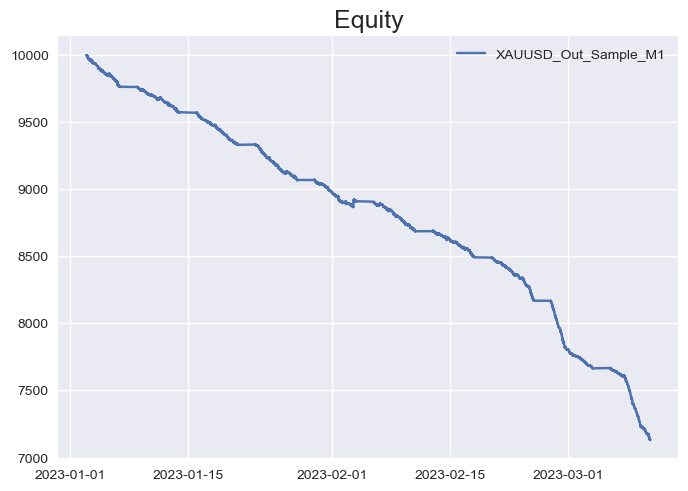

In [98]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [99]:
filename_train = f'result_{TF}_In_Sample.csv'

In [100]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')